In [136]:
import os
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

In [137]:
# 计算成对的欧式距离
def pairwise_distances(Data):
    dist_matrix = np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))
    return dist_matrix

# 计算kNN图的邻接矩阵
def nearest_neighbors(Data, n_neighbors):
    dist_matrix = pairwise_distances(Data)
    adjacency_matrix = dist_matrix.argsort(axis=1)[:, 1:n_neighbors+1]
    return adjacency_matrix

In [138]:
# 计算每个数据点的平均邻域半径
def compute_radius(Data):
    n = Data.shape[0]
    dist_matrix = pairwise_distances(Data)
    radius = np.zeros(n)
    for i in range(n):
        avg_radius = np.mean(dist_matrix[i])
        radius[i] = avg_radius
    np.savetxt('dist_matrix.csv', dist_matrix, delimiter=',')
    np.savetxt('average_radius.csv', radius, delimiter=',')
    return radius

# 以k最近邻的平均距离作为每个数据点的半径(结果表明不太行)
def compute_knn_average_radius(Data, dist_matrix, knn_matrix):
    n = Data.shape[0]
    avg_distances = np.zeros(n)
    for i in range(n):
        knn_indices = knn_matrix[i] # 第i个数据点的k个最近邻的索引
        knn_distances = [dist_matrix[i, idx] for idx in knn_indices] # 第i个数据点到k个最近邻的距离
        avg_distances[i] = np.mean(knn_distances) # 第i个数据点的k个最近邻的平均距离
    np.savetxt('knn_average_distances.csv', avg_distances, delimiter=',')
    return avg_distances

# 构建epsilon邻域的邻接矩阵
def epsilon_neighborhood(Data, epsilon):
    n_samples = Data.shape[0]
    adjacency_matrix = np.zeros((n_samples, n_samples), dtype=int)
    for i in range(n_samples):
        distances = np.sqrt(np.sum((Data[i] - Data) ** 2, axis=1))
        neighbors = np.where(distances <= epsilon)[0]
        adjacency_matrix[i, neighbors] = 1
        adjacency_matrix[neighbors, i] = 1
    return adjacency_matrix

In [139]:
# 测地距离
import heapq
# 使用优先队列（堆）实现 Dijkstra 算法
def dijkstra_shortest_path(graph, start):
    n = graph.shape[0]
    distances = np.full(n, np.inf)
    distances[start] = 0
    pq = [(0, start)]  # 优先队列，存储节点和对应的距离

    while pq:
        dist, current = heapq.heappop(pq)  # 弹出距离最小的节点
        if dist > distances[current]:
            continue
        for neighbor, weight in enumerate(graph[current]):
            if weight > 0 and dist + weight < distances[neighbor]:
                distances[neighbor] = dist + weight
                heapq.heappush(pq, (dist + weight, neighbor))  # 更新距离并入队
    return distances

In [140]:
# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, method, n_neighbors, t):
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    dist_matrix = pairwise_distances(Data)  # 计算数据集中样本点之间的距离
    knn_matrix = nearest_neighbors(Data, n_neighbors)  # 计算每个样本点的 n_neighbors 个最近邻索引
    # 用 Dijkstra 算法计算每对样本点之间的最短路径
    shortest_paths = np.zeros((n, n))
    for i in range(n):
        shortest_paths[i] = dijkstra_shortest_path(knn_matrix, i)
    if method == 'knn':
        #dist_matrix = pairwise_distances(Data)  # 计算数据集中样本点之间的距离
        #np.savetxt('dist_matrix.csv', dist_matrix, delimiter=',')
        #knn_matrix = nearest_neighbors(Data, n_neighbors)  # 计算每个样本点的 n_neighbors 个最近邻索引
        #np.savetxt('knn_matrix.csv', knn_matrix, delimiter=',')
        for i in range(len(Data)):  # 对于数据集中的每个样本点 i
            for j in knn_matrix[i]:  # 对于样本点 i 的 n_neighbors 个最近邻点 j
                Weight_matrix[i][int(j)] = np.exp(- dist_matrix[i][int(j)] ** 2 / t)  #使用热核方法计算权重
                Weight_matrix[int(j)][i] = np.exp(- dist_matrix[int(j)][i] ** 2 / t)  #邻接矩阵为对称矩阵
    elif method == 'epsilon':
        #knn_matrix = nearest_neighbors(Data, n_neighbors)  # 计算每个样本点的 n_neighbors 个最近邻索引
        radius = compute_radius(Data) # 计算每个数据点的平均邻域半径
        for i in range(n): # 对于数据集中的每个样本点 i
            adjacency_matrix = epsilon_neighborhood(Data, radius[i]) # 构建以第i个样本点为中心的epsilon邻域的邻接矩阵
            for j in range(n): # 对于数据集中的每个样本点 j
                if adjacency_matrix[i, j] == 1: # 如果样本点 j 在第i个样本点的epsilon邻域内
                    #distance = np.linalg.norm(Data[i] - Data[j]) # 计算样本点 i 和 j 之间的距离（欧式距离）
                    distance = shortest_paths[i, j] # 使用最短路径作为距离
                    Weight_matrix[i, j] = np.exp(-distance ** 2 / t)  #使用热核方法计算权重
                    Weight_matrix[j, i] = np.exp(-distance ** 2 / t)  #邻接矩阵为对称矩阵
    return Weight_matrix

def estimate_bandwidth(Data):
    std_dev = np.std(Data)
    iqr = np.percentile(Data, 75) - np.percentile(Data, 25)
    n_samples = len(Data)
    bandwidth = 0.9 * min(std_dev, iqr / 1.34) * n_samples ** (-1 / 5)
    return bandwidth

In [141]:
# 进行特征映射
def eigen_mapping(Laplacian_matrix, n_components):
    # 计算广义特征值问题的特征向量和特征值
    eigenvalues, eigenvectors = eigh(Laplacian_matrix)
    #np.savetxt('eigenvalues.csv', eigenvalues, delimiter=',')
    #np.savetxt('eigenvectors.csv', eigenvectors, delimiter=',')
    # 将特征向量按照特征值从小到大排序
    sorted_indices = np.argsort(eigenvalues)
    # 选择最小的 n_components 个特征向量
    selected_indices = sorted_indices[:n_components + 1]
    # 丢弃最小的特征向量
    selected_indices = selected_indices[1:]
    # 返回特征向量
    selected_eigenvectors = eigenvectors[:, selected_indices]
    #np.savetxt('selected_eigenvectors.csv', selected_eigenvectors, delimiter=',')
    return selected_eigenvectors

In [142]:
# LPP 算法
def LPP(Data, n_components, method, n_neighbors, t):
    # Step 1: 构建基于权重矩阵
    Weight_matrix = construct_weight_matrix(Data, method, n_neighbors, t)
    np.savetxt('Weight_matrix.csv', Weight_matrix, delimiter=',')
    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    #np.savetxt('Degree_matrix.csv', Degree_matrix, delimiter=',')
    Laplacian_matrix = Degree_matrix - Weight_matrix
    #np.savetxt('Laplacian_matrix.csv', Laplacian_matrix, delimiter=',')
    # Step 3: 进行特征映射
    selected_eigenvectors = eigen_mapping(Laplacian_matrix, n_components)
    #np.savetxt('selected_eigenvectors.csv', selected_eigenvectors, delimiter=',')
    return selected_eigenvectors

(-6.360909164736286,
 9.477276932362324,
 0.0010920470810349414,
 19.97190292286955,
 -4.814017829939432,
 7.916709742100855)

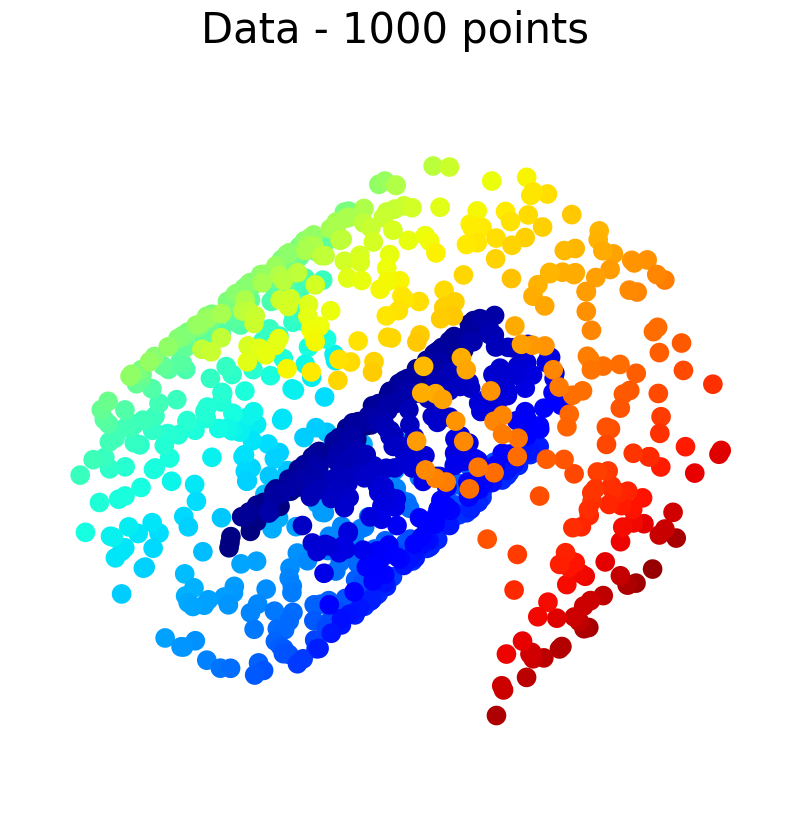

In [143]:
# 示例数据
Data = np.load('./swiss roll-1000.npy')
#np.savetxt('Data.csv', Data, delimiter=',')
# 绘制三维数据集
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Data[0, :], Data[1, :], Data[2, :], c=plt.cm.jet((Data[0, :]**2 + Data[2, :]**2) / 100), s=200, lw=0, alpha=1)
ax.set_xlim(np.min(Data[0, :]), np.max(Data[0, :]))
ax.set_ylim(np.min(Data[1, :]), np.max(Data[1, :]))
ax.set_zlim(np.min(Data[2, :]), np.max(Data[2, :]))
plt.title('Data - '+ str(Data.shape[1]) + ' points', size=30)
ax.axis("off")

In [144]:
# 将 X 格式化为 (n_samples, n_features)
Data_T = np.transpose(Data)
#np.savetxt('Data_T.csv', Data_T, delimiter=',')

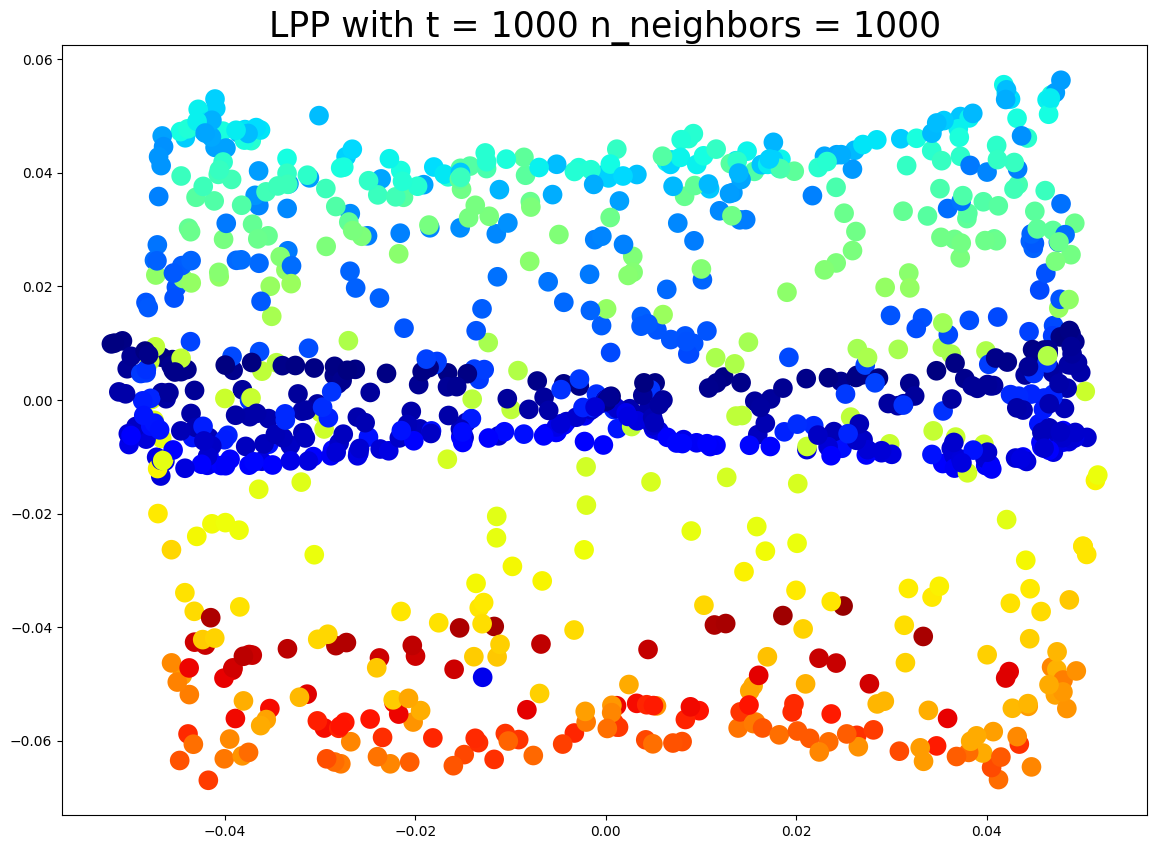

In [145]:
# 绘制及保存投影图
if not os.path.exists('output'):
    os.makedirs('output')
for method in ['epsilon']:
    plt.figure(figsize=(14, 10))
    if method == 'epsilon':
        t= 1000
        n_neighbors = 1000
        lpp_embeddings = LPP(Data_T, n_components=2, method=method, n_neighbors=n_neighbors, t=t)
        plt.title('LPP with t = ' + str(t) + ' n_neighbors = ' + str(n_neighbors), size=25)
        file_name = 'LPP_epsilon_t = ' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    elif method == 'knn':
        n_neighbors = 150
        t= 60
        lpp_embeddings = LPP(Data_T, n_components=2, method=method, n_neighbors=n_neighbors, t=t)
        plt.title('LPP with k-Nearest Neighbors = ' + str(n_neighbors) + ' and t = ' + str(t), size=25)
        file_name = 'LPP_knn_' + str(n_neighbors) + '_t=' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    plt.show()


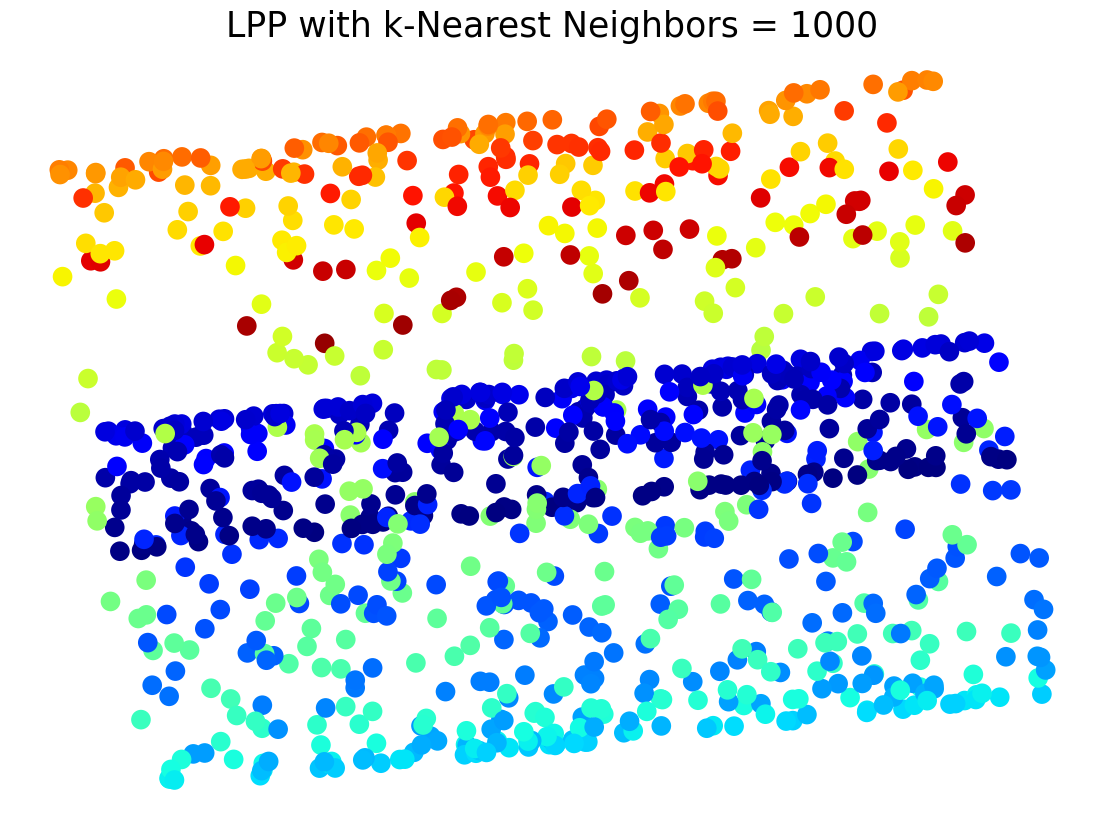

In [146]:
from lpproj import LocalityPreservingProjection
#创建 LPP 模型
lpp = LocalityPreservingProjection(n_neighbors=n_neighbors, n_components= 2)
# 使用 LPP 模型拟合瑞士卷数据集
lpp.fit(Data_T)
# 将数据集进行降维处理
y = lpp.transform(Data_T)

# 绘制投影图
plt.figure(figsize=(14,10))
plt.scatter(y[:, 0], y[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)
plt.title('LPP with k-Nearest Neighbors = ' + str(n_neighbors), size=25)
plt.axis("off")
plt.show()